In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
# Определяем функции визуализации

def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Подготовка переменных
    
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Установка процента
    
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
   # Окончательная конфигурация

    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Подготовка переменных
    
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Установка границ
    format_spines(ax)

    # Установка процента
    
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

In [6]:
# Загружаем данные

customers_ = pd.read_csv("olist_customers_dataset.csv")
order_items_ = pd.read_csv("olist_order_items_dataset.csv")
order_payments_ = pd.read_csv("olist_order_payments_dataset.csv")
orders_ = pd.read_csv("olist_orders_dataset.csv")

In [7]:
# Отображение формы данных

dataset = {
    'Customers': customers_,
    'Order Items': order_items_,
    'Payments': order_payments_,
    'Orders': orders_
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]


In [8]:
# Покажем названия колонок датасетов

for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



In [9]:
# Проверка нулевых (отсутствующих) значений в датасетах

for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Customers: False
Order Items: False
Payments: False
Orders: True


In [10]:
# подсчет набора данных с пропущенными значениями

for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



In [ ]:
'''
Несмотря на то, что отдельные наборы данных относятся к одним и тем же транзакциям, они содержат разные свойства заказа, 
потребуются такие методы, как объединение и объединение уникальных ключей, чтобы создать основной набор данных 
для целей анализа.
'''

In [11]:
# Создание основного датафрейма 

order_payments_.head()
df1 = order_payments_.merge(order_items_, on='order_id')
df2 = df1.merge(orders_, on='order_id')
df = df2.merge(customers_, on='customer_id')
print(df.shape)

(117601, 22)


In [12]:
# преобразование столбцов даты в datetime

date_columns = ['shipping_limit_date', 
                'order_purchase_timestamp', 
                'order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date', 
                'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [13]:
# очистка столбцов имен

df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()

# разработка новых/основных столбцов

df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',
                                                                                     2:'Feb',
                                                                                     3:'Mar',
                                                                                     4:'Apr',
                                                                                     5:'May',
                                                                                     6:'Jun',
                                                                                     7:'Jul',
                                                                                     8:'Aug',
                                                                                     9:'Sep',
                                                                                     10:'Oct',
                                                                                     11:'Nov',
                                                                                     12:'Dec'})

# Изменение атрибута месяца для правильного порядка

df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)

# Создание столбца года и месяца

df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [15]:
# Посмотрим на полную статистику столбщов

df.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,115034,117601,117601,117601.000000,117601,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,93317,NaN,NaN,98665,7,98111,90173,81016,95663,449,95419,NaN,4110,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,63,NaN,NaN,63,115035,63,63,63,63,649,75,NaN,18590,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,NaN,120.824783,20.045990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35051.793097,NaN,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
std,NaN,0.726692,NaN,2.774223,267.592290,0.697706,NaN,NaN,NaN,184.479323,15.861315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29820.588877,NaN,NaN,10.162307,0.505065,3.229579,1.961257,5.325670,NaN,NaN,NaN,48.798820
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,NaN,39.900000,13.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000


In [16]:
# отображение количества пропущенных значений и соответствующего процента от общего числа наблюдений

missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,order_delivered_customer_date,delivery_against_estimated,order_delivered_carrier_date,order_approved_at,month_year,order_purchase_mon,order_purchase_day,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,order_purchase_year,customer_state,customer_city,customer_zip_code_prefix,customer_unique_id,order_estimated_delivery_date,order_id,payment_sequential,order_purchase_timestamp,order_status,customer_id,freight_value,price,shipping_limit_date,seller_id,product_id,order_item_id,payment_value,payment_installments,payment_type,month_y
Values,2567.000000,2567.000000,1245.000000,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage,2.182805,2.182805,1.058664,0.012755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# удаление пропущенных значений

df.dropna(inplace=True)
df.isnull().values.any()

False

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

In [19]:
# исключаем неполные данные за 2012 год и отображаем первые 3 строки основного датафрейма

df = df.query("month_year != '2016-12' and month_year != '2016-10'")
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712


In [ ]:
'''
Основной датафрейм состоит из различных независимых наборов данных, объединенных вместе с помощью уникальных ключей. 
Столбцы даты также были преобразованы в дату и время, а для целей анализа созданы новые важные столбцы.
'''

In [ ]:
'''
ЕЖЕМЕСЯЧНЫЙ ДОХОД
'''

In [20]:
# Рассчитаем доход для каждой строки и создадим новый датафрейм со столбцами YearMonth — Revenue

df_revenue = df.groupby(['month_year'])['payment_value'].sum().reset_index()
df_revenue

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


In [ ]:
'''
Ежемесячный темп роста дохода
'''

In [21]:
# расчет ежемесячного темпа роста дохода
# использование функции pct_change() для просмотра ежемесячного процентного изменения

df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,month_year,payment_value,MonthlyGrowth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


In [ ]:
'''
Ежемесячные активные клиенты
'''

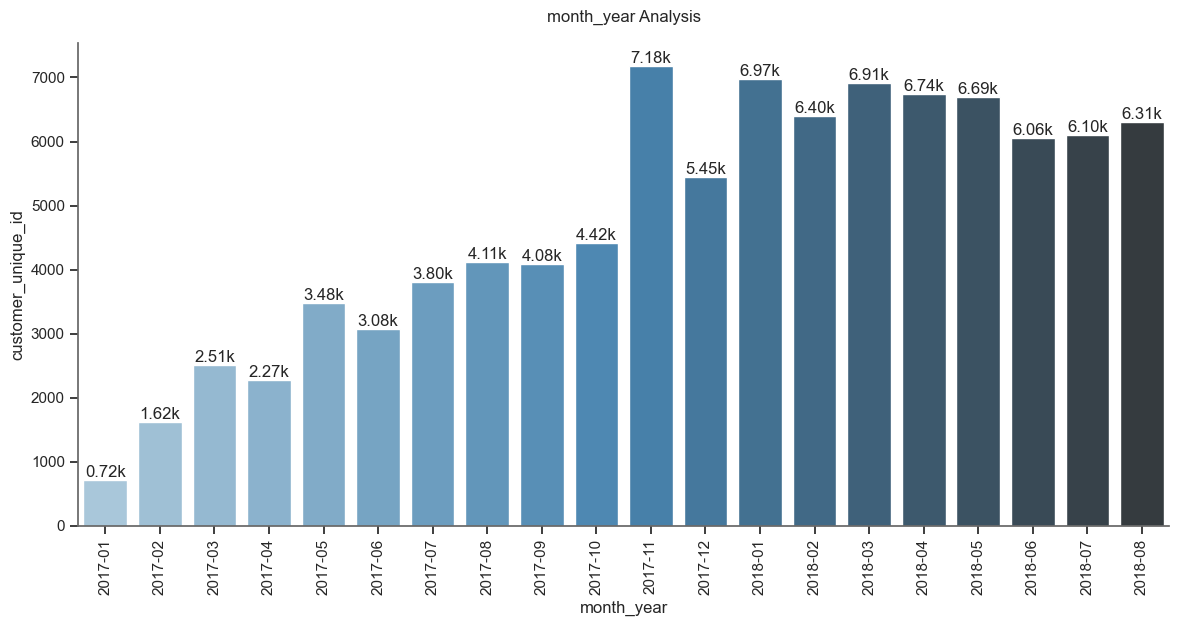

In [22]:
# создание ежемесячного датасета активных клиентов путем подсчета уникальных идентификаторов клиентов

df_monthly_active = df.groupby('month_year')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='customer_unique_id', df=df_monthly_active, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Ежемесячное количество заказов
'''

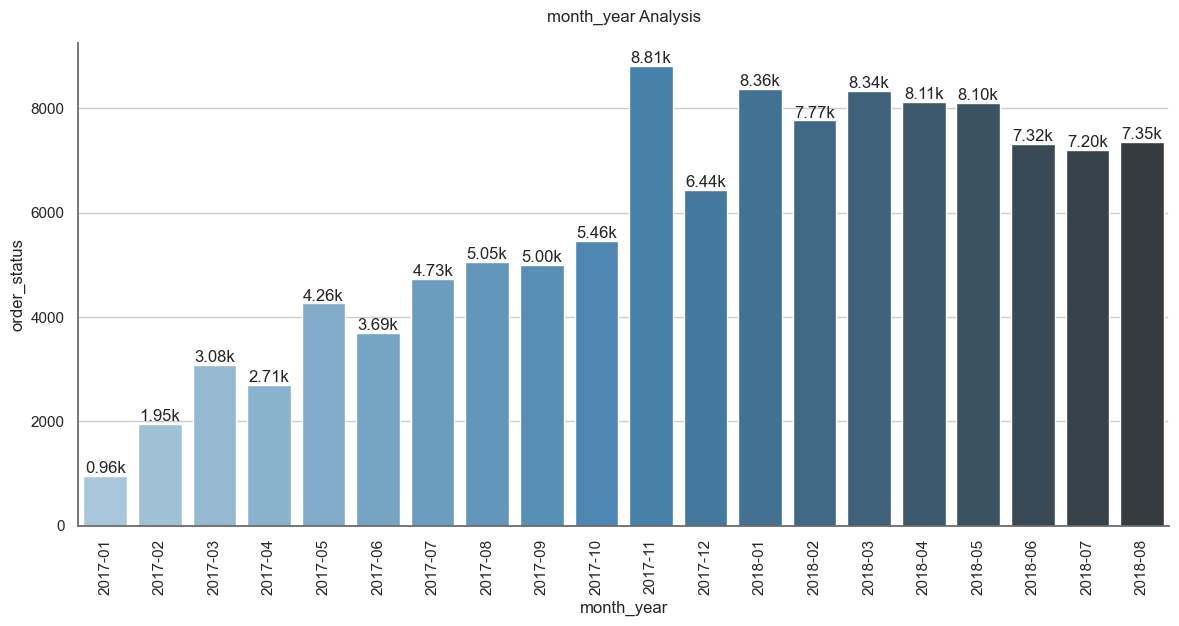

In [23]:
# Создание ежемесячного датасета активных клиентов путем подсчета уникальных идентификаторов заказов

df_monthly_sales = df.groupby('month_year')['order_status'].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='order_status', df=df_monthly_sales, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Средний доход от покупки клиента
'''

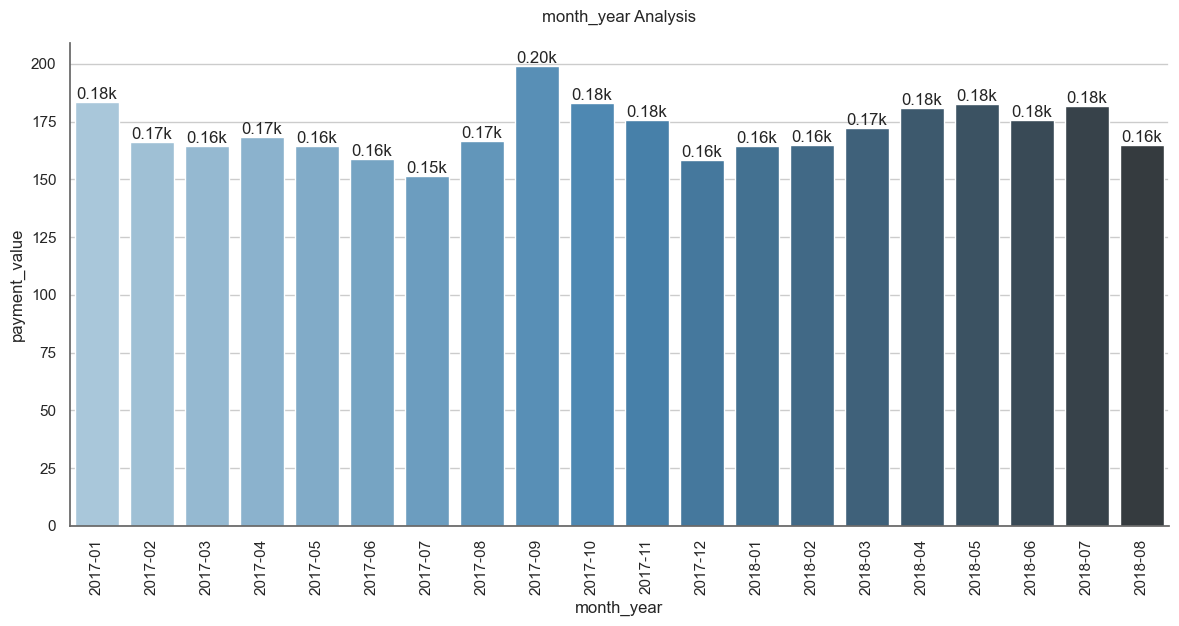

In [24]:
# создаем новый датафрейм для среднего дохода, взяв его среднее значение

df_monthly_order_avg = df.groupby('month_year')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='payment_value', df=df_monthly_order_avg, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Коэффициент новых клиентов
'''

In [25]:
# Создадим датафрейм, содержащий CustomerID и дату первой покупки

df_min_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

# объединить столбец даты первой покупки с основным датафреймом (tx_uk)

df = pd.merge(df, df_min_purchase, on='customer_unique_id')

# Создадим столбец с названием «usertype» и назначим ему «Existing»
# если Месяц года первой покупки пользователя перед выбранным месяцем года выставления счета

df['usertype'] = 'New'
df.loc[df['month_y']>df['minpurchasedate'],'usertype'] = 'Existing'

# рассчитаем доход в месяц для каждого типа пользователя

df_user_type_revenue = df.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201701,New,2017-01,176376.56
1,201702,Existing,2017-02,111.07
2,201702,New,2017-02,323704.88
3,201703,Existing,2017-03,596.38
4,201703,New,2017-03,505139.45
5,201704,Existing,2017-04,2677.76
6,201704,New,2017-04,453430.56
7,201705,Existing,2017-05,6733.95
8,201705,New,2017-05,694385.65
9,201706,Existing,2017-06,6956.06


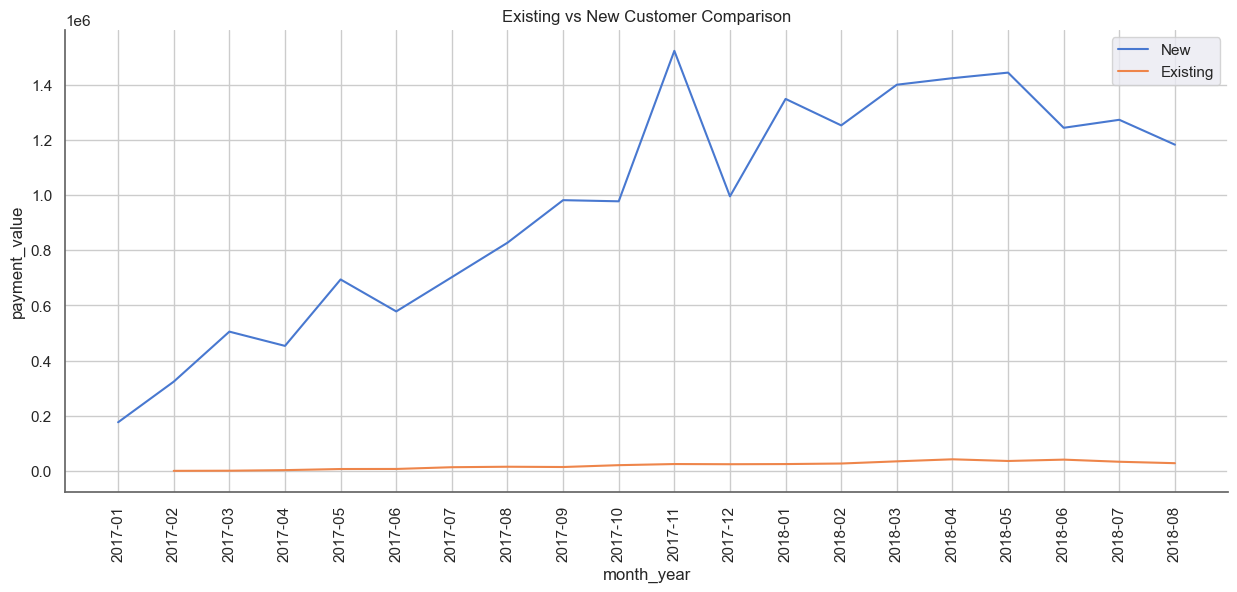

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.set(palette='muted', color_codes=True)
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'New'"), label='New')
ax = sns.lineplot(x='month_year', y='payment_value', data=df_user_type_revenue.query("usertype == 'Existing'"), label='Existing')
format_spines(ax, right_border=False)
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Коэффициент новых клиентов
'''

In [28]:
# создайте фрейм данных, который показывает соотношение новых пользователей — 
# нам также нужно удалить значения NA (коэффициент новых пользователей в первый месяц равен 0)


df_user_ratio = df.query("usertype == 'New'").groupby(['month_year'])['customer_unique_id'].nunique()/df.query("usertype == 'Existing'").groupby(['month_year'])['customer_unique_id'].nunique() 
df_user_ratio = df_user_ratio.reset_index()

# удаление значений nan, полученных за первый и последний месяц

df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ['month_year','NewCusRatio']

df_user_ratio

,month_year,NewCusRatio
1,2017-02,808.000000
2,2017-03,500.600000
3,2017-04,132.764706
4,2017-05,123.214286
5,2017-06,77.871795
6,2017-07,76.591837
7,2017-08,71.175439
8,2017-09,51.333333
9,2017-10,49.193182
10,2017-11,57.868852


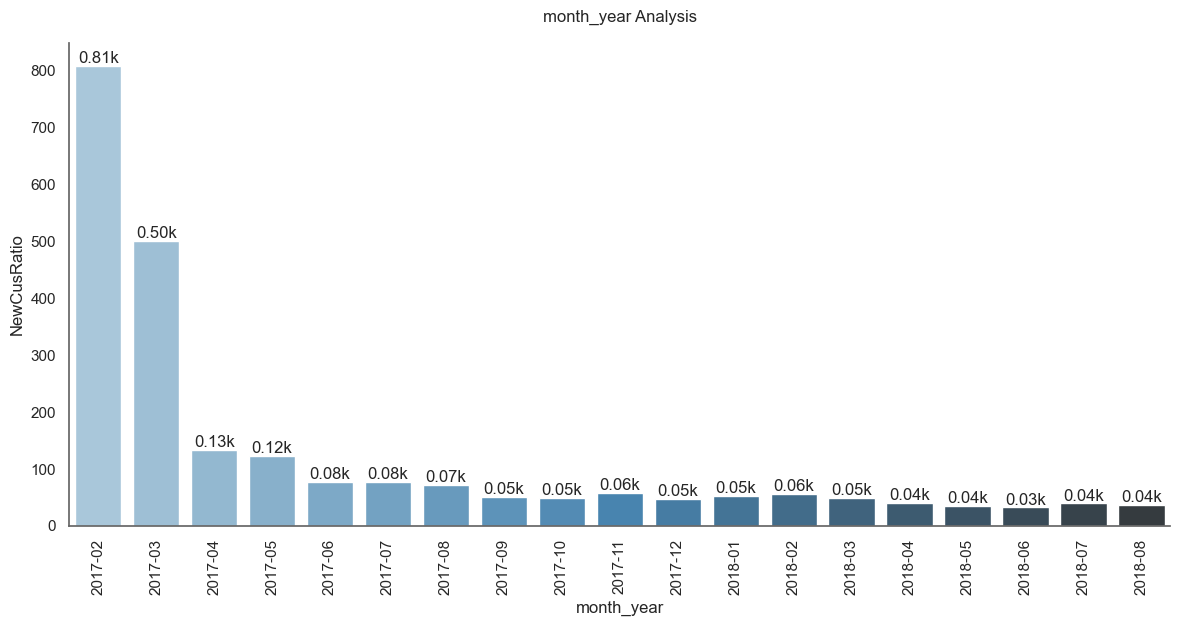

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_year', y='NewCusRatio', df=df_user_ratio, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Ежемесячный коэффициент удержания
'''

In [30]:
# Ежемесячный коэффициент удержания равен удержанным клиентам из предыдущего.
# Всего за месяц/активных клиентов (с использованием перекрестной таблицы).
# Выявление активных пользователей по их ежемесячному доходу.

df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [31]:
# Выявление активных пользователей путем просмотра количества их заказов в месяц.

df_user_purchase = df.groupby(['customer_unique_id','month_y'])['payment_value'].count().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


In [32]:
# Создадим матрицу удержания используя покупку с помощью перекрестной таблицы.

df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
df_retention.head()

month_y,customer_unique_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [33]:
# Создание словаря, в котором хранится количество сохраненных и общего количества пользователей за каждый месяц

months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
# Конвертируем массив в датафрейм и вычисляем коэффициент удержания

df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201703,2508,3,0.001196
1,201704,2274,11,0.004837
2,201705,3478,14,0.004025
3,201706,3076,16,0.005202
4,201707,3802,16,0.004208
5,201708,4114,23,0.005591
6,201709,4082,32,0.007839
7,201710,4417,32,0.007245
8,201711,7182,37,0.005152
9,201712,5450,41,0.007523


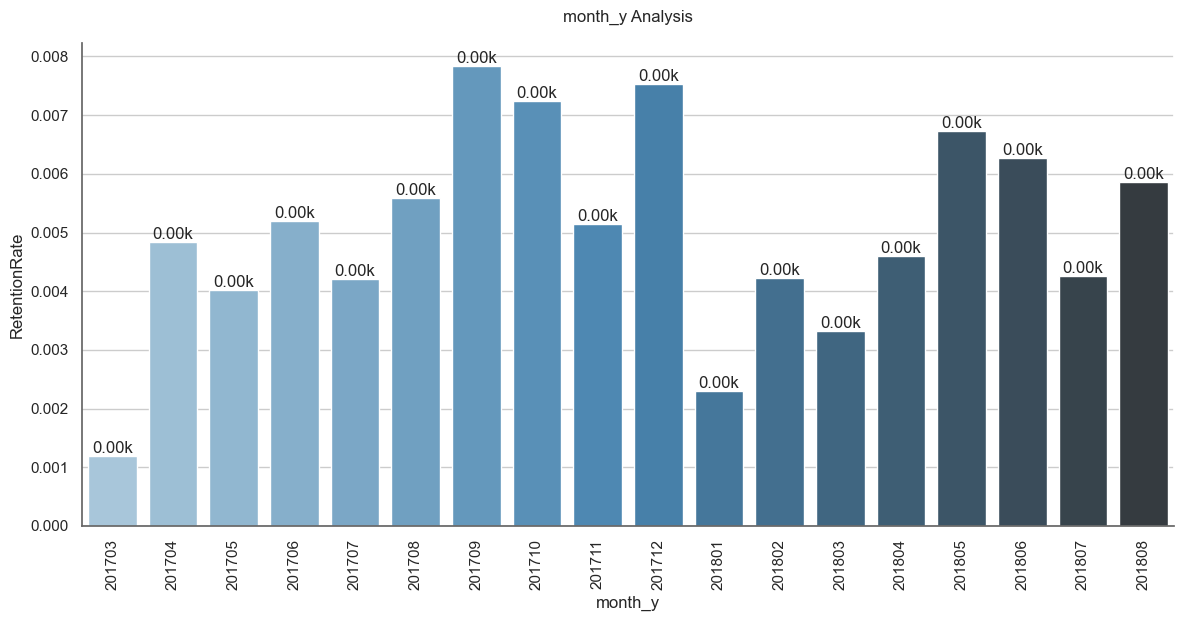

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
bar_plot(x='month_y', y='RetentionRate', df=df_retention, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [ ]:
'''
Коэффициент удержания на основе когорты
Когорты определяются как год-месяц первой покупки клиентов. 
Каждый месяц я буду измерять, какой процент клиентов удерживается после первой покупки. 
Это представление поможет понять, как недавние и старые когорты различаются по уровню удержания 
и повлияли ли недавние изменения в опыте клиентов на удержание новых клиентов или нет.
'''

In [36]:
# Создадим нашу таблицу хранения с помощью функции crosstab() — нам нужно изменить имена столбцов, 
# чтобы использовать их в функции .query().

df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['month_y']).reset_index()
new_column_names = [ 'm_' + str(column) for column in df_retention.columns]
df_retention.columns = new_column_names

# Создаем ежемесячный массив удержанных пользователей для каждой когорты

retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

# Показываем новую таблицу удержания на основе когорты

df_retention

,TotalUserCount,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
month_y,,,,,,,,,,,,,,,,,,,,
201702,1618,1.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201703,2508,NaN,1.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201704,2274,NaN,NaN,1.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201705,3478,NaN,NaN,NaN,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201706,3076,NaN,NaN,NaN,NaN,1.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201707,3802,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201708,4114,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201709,4082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00
201710,4417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00


In [ ]:
'''
Сегментация клиентов

У клиентов, которые делают покупки на Olist, разные потребности и свой профиль. 
В зависимости от этого мы должны адаптировать свои действия.

RFM означает «давность — частота — денежная стоимость». Я буду использовать эти показатели для сегментации клиентов. 
Теоретически у нас будут такие сегменты, как показано ниже: Низкая ценность: клиенты, которые менее активны, чем другие, 
не очень частые покупатели/посетители и приносят очень низкий - нулевой - возможно, отрицательный доход. 
Среднее значение: В центре всего. Частое использование нашей платформы (но не так часто, как наши High Values), 
довольно частое и приносит умеренный доход. 
Высокая ценность: группа, которую мы не хотим потерять. Высокий доход, частота и низкая неактивность.

Recency
Чтобы рассчитать давность, нам нужно узнать дату последней покупки каждого клиента и посмотреть, сколько дней они неактивны. 
После того, как нет неактивных дней для каждого клиента, мы будем применять кластеризацию K-means, 
чтобы присвоить клиентам оценку давности.
'''

In [37]:
# Создаем общий датафрейм данных для хранения CustomerID и новых показателей сегментации

df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

# Получаем максимальную дату покупки для каждого клиента и создает с ее помощью датафрейм

df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

# Принимаем нашу точку наблюдения за максимальную дату покупки в нашем датафрейме

df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

# Объединим этот датафрейм с нашим новым пользовательским датафреймом

df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,a8b9d3a27068454b1c98cc67d4e31e6f,64
2,6f70c0b2f7552832ba46eb57b1c5651e,260
3,87695ed086ebd36f20404c82d20fca87,266
4,4291db0da71914754618cd789aebcd56,28


In [40]:
df_user.Recency.describe()

count    114681.000000
mean        235.937671
std         150.795167
min           0.000000
25%         113.000000
50%         217.000000
75%         344.000000
max         601.000000
Name: Recency, dtype: float64

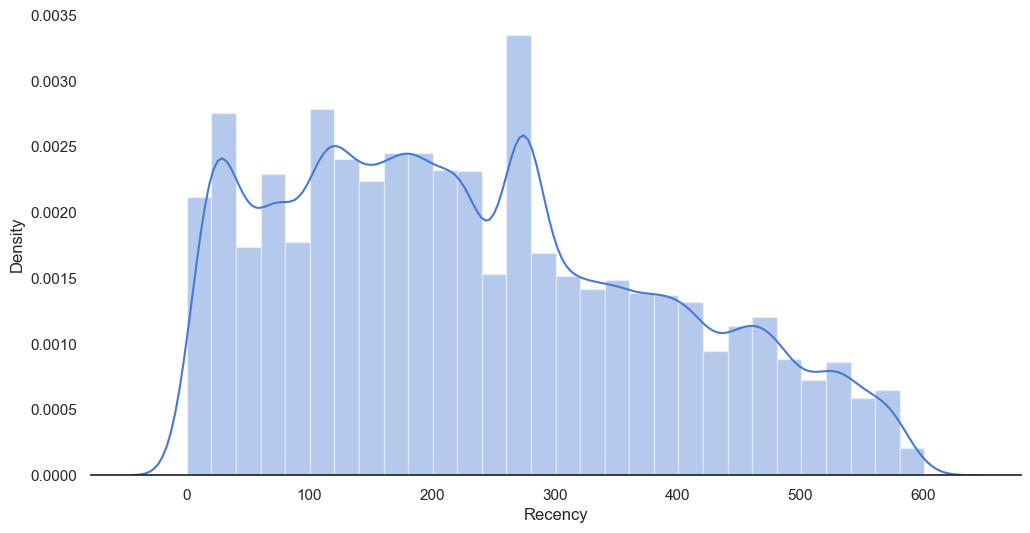

In [41]:
# Построение графика распределения непрерывного набора призников

sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

In [ ]:
'''
Будем применять кластеризацию K-means, чтобы присвоить каждому клиенту оценку новизны. 
Но нужно сказать, сколько кластеров мне нужно для алгоритма K-means. 
Чтобы выяснить это, применим Elbow Method. 
Elbow Method просто определяет оптимальное количество кластеров для оптимальной инерции.
'''

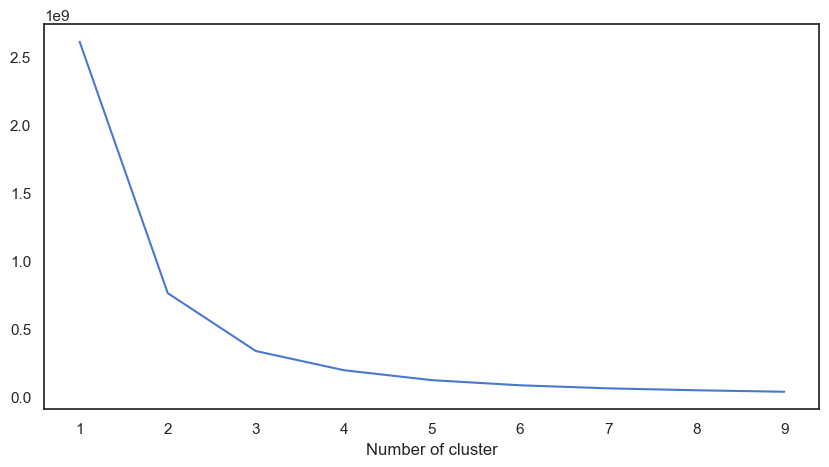

In [42]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
'''
Похоже, что 3 или 4 — оптимальное количество кластеров. 
В зависимости от бизнес-требований могно использовать меньшее или большее количество кластеров. 
В этом случае выберем 5.
'''

In [44]:
# Построение 5 кластеров на предмет актуальности и добавление их в dataframe

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

# Функция для упорядочивания номеров кластеров

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

# Отображение статистики каждого кластер

df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,14520.0,503.543595,42.605553,440.0,467.0,496.0,537.0,601.0
1,18398.0,375.236439,33.801377,319.0,346.0,375.0,404.0,439.0
2,27252.0,260.219874,31.029973,207.0,231.0,265.0,281.0,318.0
3,29976.0,152.353082,30.925276,101.0,125.0,153.0,180.0,206.0
4,24535.0,48.260322,27.790662,0.0,24.0,44.0,73.0,100.0


In [ ]:
'''
Судя по приведенной выше таблице, кластеры недавности имеют разные характеристики. 
Клиенты в кластере 4 появились совсем недавно по сравнению с кластерами 3 и 2. 
Следовательно, кластер 4 охватывает наиболее активных клиентов, тогда как кластер 0 охватывает наиболее неактивных клиентов
'''

In [ ]:
'''
Frequency
Чтобы создать кластеры частот (Frequency), нужно будет найти общее количество заказов для каждого клиента, 
после чего можно разместить их в различных кластерах.
'''

In [45]:
# Получим количество заказов для каждого пользователя и создадим с его помощью датафрейм

df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Добавьте эти данные в наш основной датафрейм

df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

# Получим таблицу сводной статистики

df_user.Frequency.describe()

count    114681.000000
mean          1.777496
std           2.774387
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          75.000000
Name: Frequency, dtype: float64

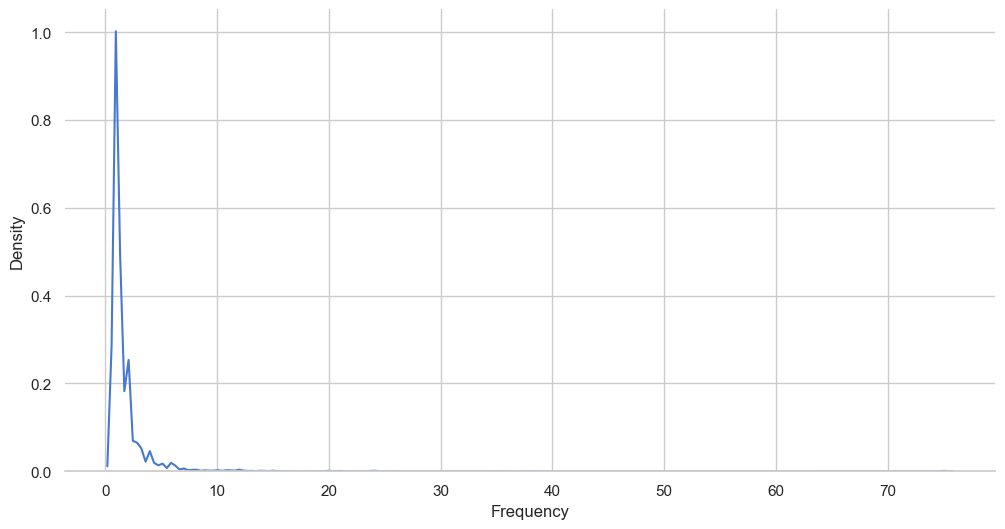

In [46]:
# Построение графика распределения непрерывных призников

sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [47]:
# K-means

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

# Упорядочиваем frequency кластер

df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

# Просмотрим статистику каждого кластера

df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,99875.0,1.207900,0.405807,1.0,1.0,1.0,1.0,2.0
1,12870.0,4.039005,1.186489,3.0,3.0,4.0,5.0,7.0
2,1464.0,10.831967,2.252463,8.0,9.0,11.0,12.0,16.0
3,397.0,24.536524,6.099081,18.0,20.0,22.0,24.0,38.0
4,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


In [ ]:
'''
Как и в случае с кластерами недавности, более высокая частота указывает на лучших клиентов.
'''

In [ ]:
'''
Revenue
Давайте посмотрим, как будет выглядеть наша клиентская база, если я сгруппирую ее по доходам. 
Рассчитаем доход для каждого клиента, построим гистограмму и применим тот же метод кластеризации.
'''

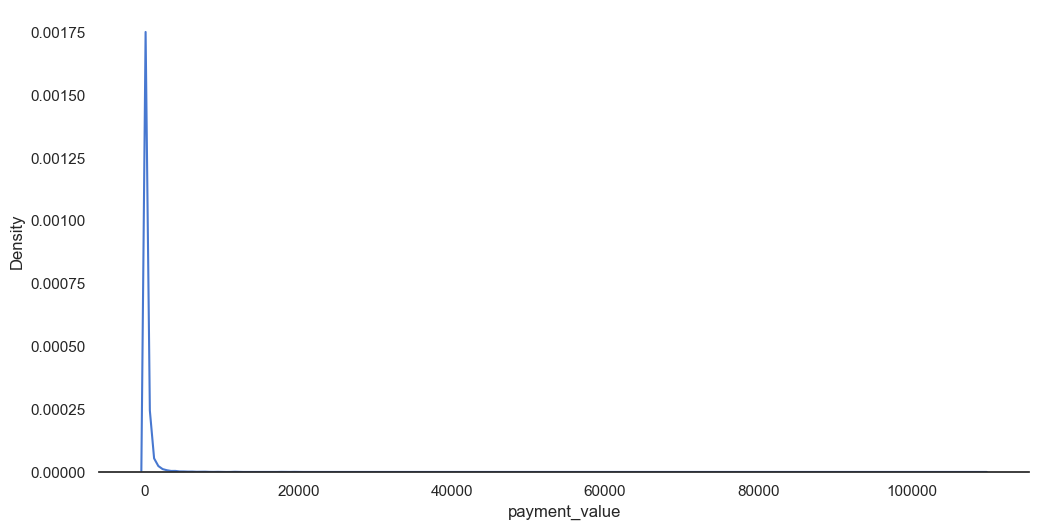

In [48]:
# Рассчитаем доход по каждому клиента

df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

# Объединяем его с основным датафреймом

df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

# Построение графика распределения

sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

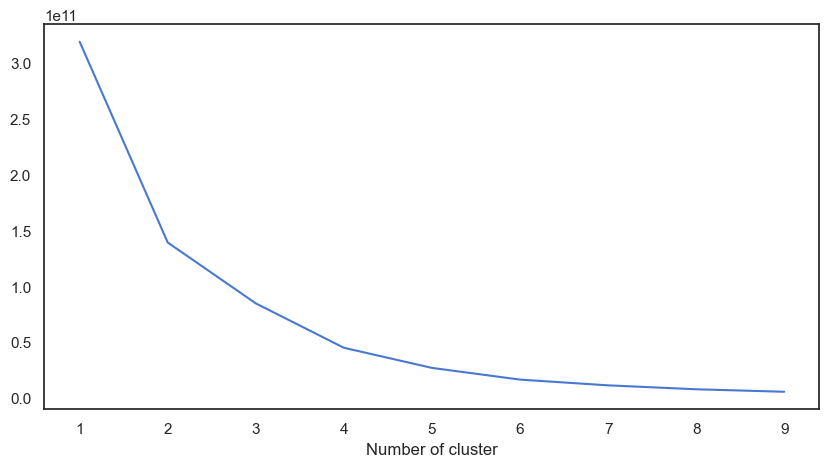

In [49]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [50]:
# Применим кластеризацию с количеством кластеров 6

kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])

# Упорядочиваем номера кластеров

df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

# Смотрим статистику

df_user.groupby('RevenueCluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,108243.0,193.122365,192.269426,9.59,67.56,124.36,233.9200,1044.68
1,5474.0,1899.533999,827.193455,1045.48,1263.87,1620.75,2236.5325,4462.87
2,726.0,7059.829215,2126.601433,4483.28,5300.64,6323.04,7971.8800,12490.88
3,184.0,20278.110435,5207.417793,14196.28,16313.60,19174.38,25051.8900,30186.00
4,46.0,43587.292174,2837.177072,36489.24,44048.00,44048.00,45256.0000,45256.00
5,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.6400,109312.64


In [ ]:
'''
Общая оценка
После создания различных показателей метрик (номеров кластеров) для актуальности, частоты и дохода. 
Перейдем к вычислению из них общей оценки:
'''

In [51]:
# Переименование колонок

df_user.columns = ['customer_unique_id', 
                   'Recency', 
                   'RecencyCluster', 
                   'Frequency', 
                   'FrequencyCluster', 
                   'Monetary', 
                   'RevenueCluster']

# Подсчитаем общиую оценку используя mean().

df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,502.971622,1.207892,166.477076
1,385.364741,1.378547,199.565570
2,272.431150,1.466236,222.061057
3,169.069667,1.585066,255.642186
4,69.472702,1.694201,306.754455
5,103.868056,6.005342,1224.089874
6,90.693560,6.717246,3067.311340
7,115.170115,12.025287,6036.510161
8,154.866667,12.030303,23948.324485


In [ ]:
'''
Приведенная выше оценка ясно показывает, что клиенты с оценкой 12 — наши лучшие клиенты, тогда как 0 — худшие. 
Для простоты лучше назовем эти баллы: от 0 до 4: низкое значение,
от 5 до 7: среднее значение, 
8+: высокое значение.
'''

In [54]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

df_user.sample(20)

,customer_unique_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
85949,dad72f3eb9e5d21519271868d9c5f943,518,0,1,0,305.19,0,0,Low-Value
95764,00cc8551c0621bc65a440e836bb652d7,523,0,1,0,95.22,0,0,Low-Value
53827,4e45d04dd97c6185e03a374d0024ec04,242,2,1,0,87.76,0,2,Low-Value
24176,c4aaf56cb82d8cafad1c2281fd3e3bd3,137,3,1,0,98.53,0,3,Low-Value
48483,9070542e9f555b696dbaf24eb656fc4e,242,2,1,0,25.10,0,2,Low-Value
72987,acea597872fc3f407ede7c684918d57c,338,1,1,0,544.90,0,1,Low-Value
20370,46eea84161fc3fbb4040fd02b046a70c,125,3,1,0,262.35,0,3,Low-Value
81116,20ba2d4380b84306d894aec13ef08bc7,336,1,1,0,126.48,0,1,Low-Value
34901,7e16dc849b8d954febd4c2ab9a1b1c60,40,4,1,0,85.81,0,4,Mid-Value
61973,611498b1bc11746dc68c832f54eb55ae,224,2,2,0,133.80,0,2,Low-Value


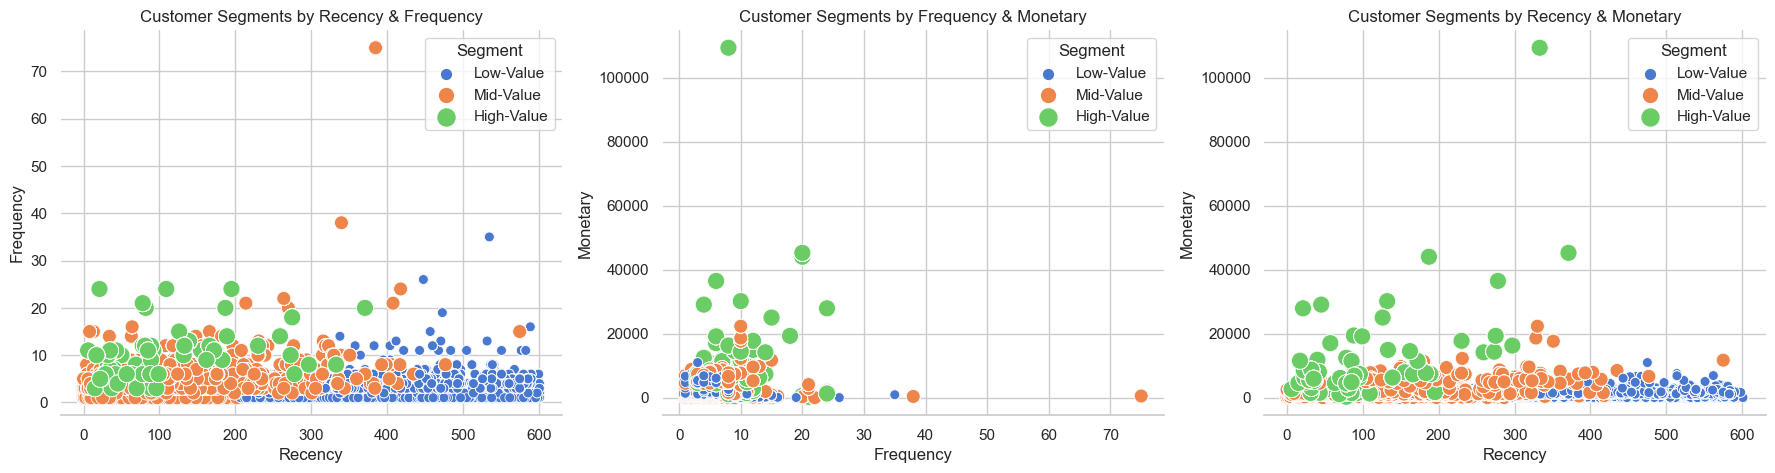

In [55]:
# Построение графика распределения непрерывного набора признаков

sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()